# Decision trees

## Idea

The idea is simple: for a given observation perform a series of True / False tests with given features. The result should lead to some prediction. To implement this idea we need to determine:
1. What exactly we will predict at each step. Intuitively the answer can be simple: predict the most frequent class (classification) or the mean value (regression). But these iseas can be supported mathematically why they're any good.
2. When we should stop "making branches"? Otherwise we can just memorize the whole dataset. In other words, we need to limit overfitting. This includes:
    * Limit max depth of a tree
    * Limit min samples in a leaf
    * Limit max number of leaves in the resulting tree
    * Split the branches only if it improves the criteria on n precent
3. What a "good split" mean. To explain this we need to determine some loss function (a function that expresses IMPURITY of the data) and find such a split that reduces the loss the most RIGHT NOW (greedy algorythm). Reducing the resulting impurity = increasing the drop of impurity:
$$
H(X_m) - \frac{|X_l|}{|X_m|}H(X_l) - \frac{|X_r|}{|X_m|}H(X_r) => max
$$
    * In regression it can be expressed this way: if we predict the mean of target in each split, we want such a mean value that will make the resulting total variance as little as possible.
    * In classification we can go MLE way and say we want such a split that will give the maximum probability of our X (or minimum minus log probability). It's called entropy impurity, or Shennon entropy:
$$
H(X) = - \sum^{k=1}_{K}p_k \log p_k
$$
where: $p_k$ - probability of predicting k-th class with $c_k$ constant for given X

    * Gini impurity in classification (Brier score)
    
$$
H(X) = \sum^{k=1}_{K} p_k (1 - p_k) = 1 - \sum^{k=1}_{K} p^2_k
$$


## Implementation

In [173]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [4]:
data = pd.read_csv('datasets/spaceship_titanic/train.csv')
data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [6]:
data = data[['HomePlanet', 'Age', 'Spa', 'VRDeck', 'Transported']].dropna()

# target encoding for categorical features:
planet_codes = data.groupby('HomePlanet').agg(mean_value=('Transported', 'mean'))['mean_value'].to_dict()
data['HomePlanet'] = data['HomePlanet'].apply(lambda x: planet_codes[x])

data['Transported'] = data['Transported'].astype(int)

data.head()

,HomePlanet,Age,Spa,VRDeck,Transported
0,0.657685,39.0,0.0,0.0,0
1,0.424658,24.0,549.0,44.0,1
2,0.657685,58.0,6715.0,49.0,0
3,0.657685,33.0,3329.0,193.0,0
4,0.424658,16.0,565.0,2.0,1


In [160]:
X = data.drop('Transported', axis=1).values
y = data['Transported'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, stratify=y, random_state=42)

In [168]:
import numpy as np

class Node:
    def __init__(self, feature=None, threshold=None, left_child=None, right_child=None, leaf_value=None):
        self.feature = feature
        self.threshold = threshold
        self.left_child = left_child
        self.right_child = right_child
        self.leaf_value = leaf_value

class TreeClassifier:
    def __init__(self, max_depth=0):
        self.max_depth = max_depth
        return
    
    def entropy(self, y):
        unique_labels = np.unique(y)
        entropy = 0
        for label in unique_labels:
            p = np.sum(y == label) / len(y)
            entropy += -p * np.log(p)
        return entropy
    
    def grow_tree(self, X, y, depth=0):
        n_samples = X.shape[0]
        n_labels = len(np.unique(y))
        
        labels, counts = np.unique(y, return_counts=True)
        # print(f'labels, counts: {labels}, {counts}')
        
        # Check if all columns have only one constant value
        n_uniques = np.apply_along_axis(lambda x: len(np.unique(x)), axis=0, arr=X)
        x_is_constant = np.all(n_uniques == 1)
        
        # stopping criteria:
        stop_criteria = (depth >= self.max_depth
                         or n_labels == 1
                         or n_samples < 2
                         or x_is_constant)
        
        if stop_criteria:
            uniq, counts = np.unique(y, return_counts=True)
            best_index = np.argmax(counts)
            prediction = uniq[best_index]
            # print(f'Created a leaf, predicted class: {prediction}')
            return Node(leaf_value=prediction)
        
        best_new_entropy = np.inf
        for feature in range(X.shape[1]):
            unique_values = sorted(np.unique(X[:, feature]))
            for threshold in unique_values[1:]:
                left_index = X[:, feature] < threshold
                right_index = X[:, feature] >= threshold
                y_left = y[left_index]
                y_right = y[right_index]
                
                left_entropy = self.entropy(y_left)
                right_entropy = self.entropy(y_right)
                
                l_weighted_entropy = left_entropy * len(y_left) / len(y)
                r_weighted_entropy = right_entropy * len(y_right) / len(y)
                new_entropy = l_weighted_entropy + r_weighted_entropy

                if new_entropy < best_new_entropy:
                    best_new_entropy = new_entropy
                    best_threshold = threshold
                    best_feature = feature
                    
        left_index = X[:, best_feature] < best_threshold
        right_index = X[:, best_feature] >= best_threshold
        
        # print(f'best_feature: {best_feature}, best_threshold: {best_threshold}, len_left: {sum(left_index)}, len_right: {sum(right_index)}')
        
        left_child = self.grow_tree(X[left_index, :], y[left_index], depth=depth + 1)
        right_child = self.grow_tree(X[right_index, :], y[right_index], depth=depth + 1)
        
        return Node(feature=best_feature, threshold=best_threshold, left_child=left_child, right_child=right_child, leaf_value=None)
    
    def fit(self, X, y):
        self.root = self.grow_tree(X, y)
        return self.root
    
    def predict(self, X):
        return np.array([self.predict_tree(x, self.root) for x in X])
    
    def predict_tree(self, x, node):
        if node.leaf_value is not None:
            return node.leaf_value
        
        if x[node.feature] < node.threshold:
            return self.predict_tree(x, node.left_child)
        else:
            return self.predict_tree(x, node.right_child)
    

tree_classifier = TreeClassifier(max_depth=3)
root = tree_classifier.fit(X_train, y_train)

In [190]:
pred_train = tree_classifier.predict(X_train)
pred_test = tree_classifier.predict(X_test)

print('Score train:', balanced_accuracy_score(y_train, pred_train))
print('Score test', balanced_accuracy_score(y_test, pred_test))

Score train: 0.8597713156575837
Score test 0.6983104470824091


In [172]:
train_scores = []
test_scores = []

for depth in range(20):
    tree_classifier = TreeClassifier(max_depth=depth)
    root = tree_classifier.fit(X_train, y_train)
    
    pred_train = tree_classifier.predict(X_train)
    pred_test = tree_classifier.predict(X_test)

    train_scores.append(balanced_accuracy_score(y_train, pred_train))
    test_scores.append(balanced_accuracy_score(y_test, pred_test))

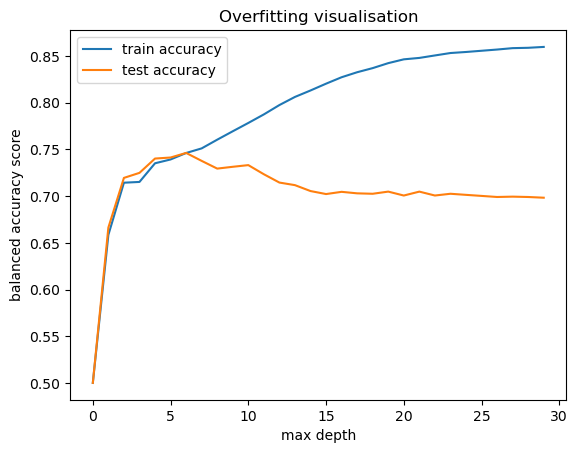

In [188]:
plt.plot(train_scores, label='train accuracy')
plt.plot(test_scores, label='test accuracy')

plt.xlabel('max depth')
plt.ylabel('balanced accuracy score')
plt.title('Overfitting visualisation')
plt.legend()
plt.show()